## Data analysis

In [3]:
# Data analysis of dataset
import os
import cv2
import matplotlib.pyplot as plt


In [4]:
# Sample amounts

PATH_TRAIN = './datasets/train/images'
PATH_VALID = './datasets/valid/images'
PATH_TEST = './datasets/test/images'

# Count of samples
train_samples = len(os.listdir(PATH_TRAIN))
valid_samples = len(os.listdir(PATH_VALID))
test_samples = len(os.listdir(PATH_TEST))
total_samples = train_samples + valid_samples + test_samples

print(f'Train samples: {train_samples}, {train_samples/total_samples*100:.2f}%')
print(f'Valid samples: {valid_samples}, {valid_samples/total_samples*100:.2f}%')
print(f'Test samples: {test_samples}, {test_samples/total_samples*100:.2f}%')

Train samples: 2712, 75.02%
Valid samples: 453, 12.53%
Test samples: 450, 12.45%


Initial number of images files: 2712
Initial number of labels files: 2712
Total usable images and labels after filtering: 2712
Missing annotations: []
Number of images: 2712
Number of labels: 5318
Image dimensions: (128, 1024, 3)


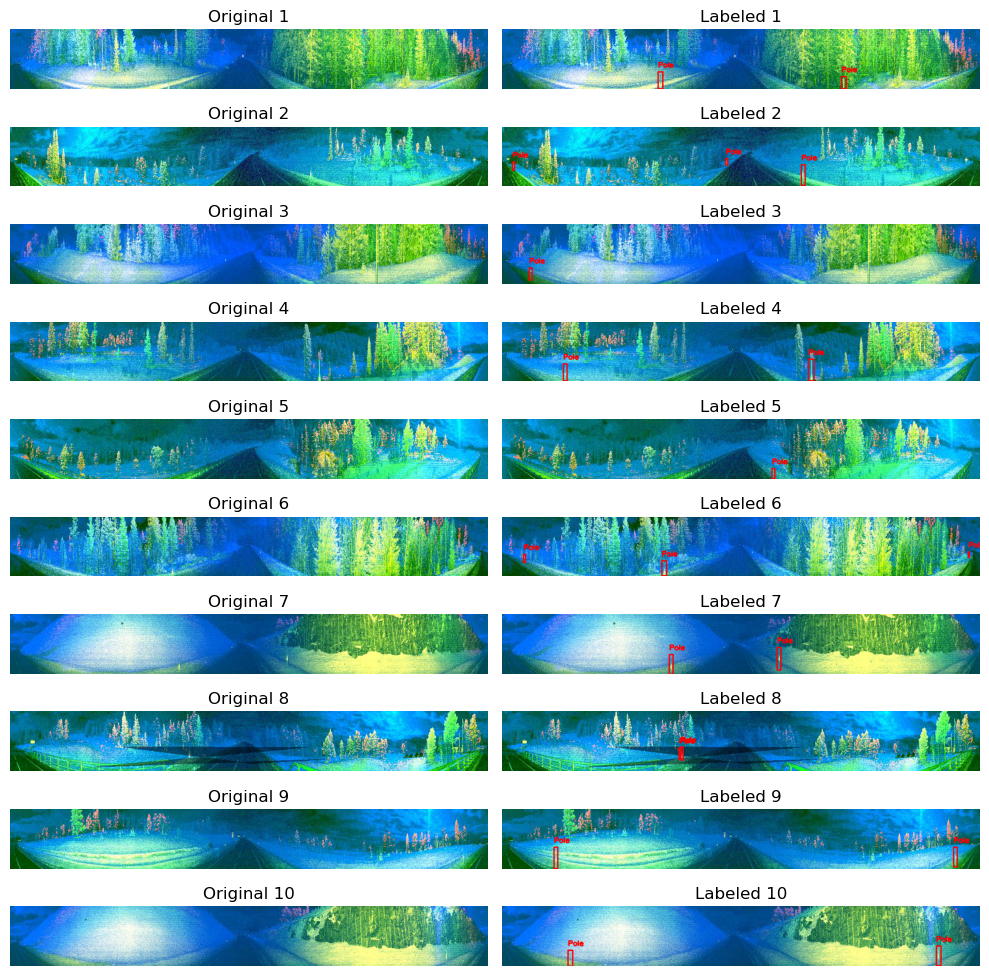

In [7]:

# Load images

PATH = "datasets"
IM_PATH = PATH + "/train/images"
LA_PATH = PATH + "/train/labels"
image_files = sorted([f.split('.jpg')[0] for f in os.listdir(IM_PATH) if f.endswith('.jpg')])
label_files = sorted([f.split('.txt')[0] for f in os.listdir(LA_PATH) if f.endswith('.txt')])

matching_files = set(image_files).intersection(label_files)

# Display number of images and labels
print("Initial number of images files:", len(image_files))
print("Initial number of labels files:", len(label_files))
print("Total usable images and labels after filtering:", len(matching_files))

IMAGE_PATHS = [os.path.join(IM_PATH, f + '.jpg') for f in matching_files]
LABEL_PATHS = [os.path.join(LA_PATH, f + '.txt') for f in matching_files]


# Check for missing annotations
missing_annotations = []
for i, label_path in enumerate(LABEL_PATHS):
    with open(label_path, 'r') as label_file:
        labels = label_file.read().splitlines()
    if not labels:
        missing_annotations.append(i)

print("Missing annotations:", missing_annotations)

# Display number of images and labels
total_labels = sum(len(open(label_path, 'r').read().splitlines()) for label_path in LABEL_PATHS)
print("Number of images:", len(IMAGE_PATHS))
print("Number of labels:", total_labels)

# Display dimensions of the images
print("Image dimensions:", cv2.imread(IMAGE_PATHS[0]).shape)

# Function to overlay labels on an image
def overlay_labels(image_path, label_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load the corresponding label file
    with open(label_path, 'r') as label_file:
        labels = label_file.read().splitlines()

    # Overlay labels on the image
    for l in labels:
        # Parse label: format is "class x_center y_center width height"
        label_data = l.split()
        cls, x_center, y_center, width, height = map(float, label_data)
        
        # Convert YOLO format (normalized) to pixel values
        img_h, img_w = image.shape[:2]
        x_center = int(x_center * img_w)
        y_center = int(y_center * img_h)
        width = int(width * img_w)
        height = int(height * img_h)

        # Calculate top-left and bottom-right corners
        x1 = x_center - width // 2
        y1 = y_center - height // 2
        x2 = x_center + width // 2
        y2 = y_center + height // 2

        # Draw the rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Optionally, display the class label
        cv2.putText(image, f"Pole", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return image

# Display the first 5 images with labels
num_images_to_display = 10
plt.figure(figsize=(10, 10))

for i in range(num_images_to_display):
    # Load the original image
    original_image = cv2.imread(IMAGE_PATHS[i])
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Overlay labels on the image
    labeled_image = overlay_labels(IMAGE_PATHS[i], LABEL_PATHS[i])
    
    # Add subplot for the original image (left column)
    plt.subplot(num_images_to_display, 2, 2 * i + 1)
    plt.imshow(original_image)
    plt.axis('off')  # Hide axes for better visualization
    plt.title(f"Original {i + 1}")

    # Add subplot for the labeled image (right column)
    plt.subplot(num_images_to_display, 2, 2 * i + 2)
    plt.imshow(labeled_image)
    plt.axis('off')  # Hide axes for better visualization
    plt.title(f"Labeled {i + 1}")

plt.tight_layout()
plt.show()

From this we can see that the poles most frequently are places at the bottom of the 

In [2]:
# Initialize variables to calculate total label area and total image area
total_label_area = 0
total_image_area = 0

# Loop through all images and labels
for image_path, label_path in zip(IMAGE_PATHS, LABEL_PATHS):
    # Load the image to get dimensions
    image = cv2.imread(image_path)
    img_h, img_w = image.shape[:2]
    image_area = img_h * img_w
    total_image_area += image_area  # Add the area of the current image to the total

    # Load the corresponding label file
    with open(label_path, 'r') as label_file:
        labels = label_file.read().splitlines()

    # Calculate the area of each bounding box
    for l in labels:
        # Parse label: format is "class x_center y_center width height"
        _, x_center, y_center, width, height = map(float, l.split())
        
        # Convert normalized width and height to pixel values
        width_px = width * img_w
        height_px = height * img_h

        # Calculate the area of the bounding box
        bbox_area = width_px * height_px
        total_label_area += bbox_area  # Add the bounding box area to the total

# Calculate the ratio of label area to image area
label_to_image_ratio = total_label_area / total_image_area

# Display the results
print("Total label area:", total_label_area)
print("Total image area:", total_image_area)
print("Ratio of label area to image area:", label_to_image_ratio)
print(f"Percentage of image area covered by labels: {label_to_image_ratio * 100:.2f}%")

Total label area: 1487029.5673879024
Total image area: 379322368
Ratio of label area to image area: 0.003920226416460372
Percentage of image area covered by labels: 0.39%


In [3]:
bbox_areas = []

# Loop through each .txt file in the directory
for file in LABEL_PATHS:
    with open(file, 'r') as f:
        annotations = f.readlines()  # Read all lines in the file
        for annotation in annotations:
            # Parse each line in YOLO format: class_id x_center y_center width height
            _, x_center, y_center, width, height = map(float, annotation.split())
            
            # Calculate the bounding box area (YOLO dimensions are normalized)
            area = width * height  # Area in normalized units (as fraction of image area)
            bbox_areas.append(area)

# Calculate and print the average bounding box area
print(f"Average bounding box area as ratio of image: {sum(bbox_areas)/len(bbox_areas):.6f}")


counts = []

# Loop through each .txt file in the directory
for file in LABEL_PATHS:
    with open(file, 'r') as f:
        annotations = f.readlines()  # Read all lines in the file
        counts.append(len(annotations))  # Count the number of lines (objects)

# Calculate and print the average poles per image
print(f"Average poles per image: {sum(counts)/len(counts):.2f}")


Average bounding box area as ratio of image: 0.001897
Average poles per image: 2.07
